In [1]:
pip install numpy matplotlib


In [3]:
import numpy as np

NUM_BITS = 10000

# Generate raw digital data
bits = np.random.randint(0, 2, NUM_BITS)

print("Total bits:", len(bits))
print("First 30 bits:", bits[:30])
print("1s:", np.sum(bits), "0s:", NUM_BITS - np.sum(bits))


Total bits: 10000
First 30 bits: [0 1 0 1 0 0 1 1 1 0 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1]
1s: 4960 0s: 5040


In [5]:
# BPSK modulation
signal = 2 * bits - 1

print("First 20 signal values:")
print(signal[:20])


First 20 signal values:
[-1  1 -1  1 -1 -1  1  1  1 -1  1  1 -1 -1  1 -1  1 -1 -1 -1]


In [7]:
# adding noise
def add_awgn(signal, snr_db):
    snr_linear = 10 ** (snr_db / 10)
    noise_power = 1 / snr_linear
    noise = np.sqrt(noise_power) * np.random.randn(len(signal))
    return signal + noise

snr_db = 5  # try 0, 5, 10 later
noisy_signal = add_awgn(signal, snr_db)

print("Signal sample:", signal[:10])
print("Noisy signal sample:", noisy_signal[:10])


Signal sample: [-1  1 -1  1 -1 -1  1  1  1 -1]
Noisy signal sample: [-1.40955092  0.35947775 -0.99213159  0.56289745 -0.84448929 -0.13287699
  2.25335732  1.53170697  0.5143833  -0.75661316]


In [9]:
received_bits = (noisy_signal > 0).astype(int)

errors = np.sum(bits != received_bits)
ber = errors / NUM_BITS

print("Errors:", errors)
print("Bit Error Rate (BER):", ber)


Errors: 363
Bit Error Rate (BER): 0.0363


In [11]:
snr_values = range(0, 16)
ber_values = []

for snr in snr_values:
    noisy = add_awgn(signal, snr)
    recovered = (noisy > 0).astype(int)
    ber = np.mean(bits != recovered)
    ber_values.append(ber)

print(list(zip(snr_values, ber_values)))


[(0, 0.1539), (1, 0.1276), (2, 0.1023), (3, 0.0778), (4, 0.0572), (5, 0.0388), (6, 0.0228), (7, 0.0133), (8, 0.0066), (9, 0.0022), (10, 0.0006), (11, 0.0002), (12, 0.0001), (13, 0.0), (14, 0.0), (15, 0.0)]


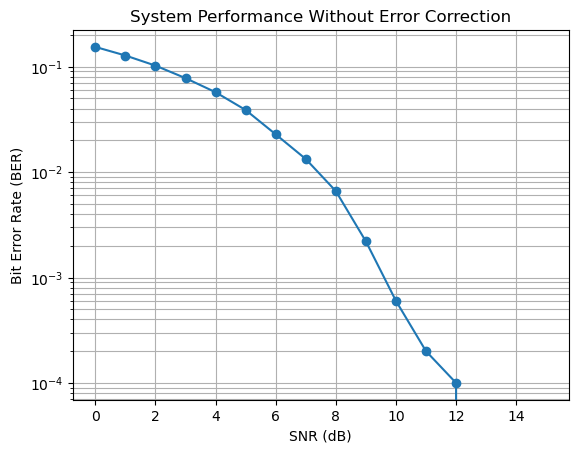

In [13]:
import matplotlib.pyplot as plt

plt.semilogy(snr_values, ber_values, marker='o')
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.title("System Performance Without Error Correction")
plt.grid(True, which="both")
plt.show()


In [15]:
def hamming74_encode(bits):
    bits = bits.reshape(-1, 4)

    d1, d2, d3, d4 = bits[:,0], bits[:,1], bits[:,2], bits[:,3]

    p1 = d1 ^ d2 ^ d4
    p2 = d1 ^ d3 ^ d4
    p3 = d2 ^ d3 ^ d4

    encoded = np.column_stack((p1, p2, d1, p3, d2, d3, d4))
    return encoded.reshape(-1)


In [17]:
def hamming74_decode(bits):
    bits = bits.reshape(-1, 7)

    p1, p2, d1, p3, d2, d3, d4 = bits.T

    s1 = p1 ^ d1 ^ d2 ^ d4
    s2 = p2 ^ d1 ^ d3 ^ d4
    s3 = p3 ^ d2 ^ d3 ^ d4

    syndrome = s1 + 2*s2 + 4*s3

    for i in range(len(syndrome)):
        if syndrome[i] != 0:
            bits[i, syndrome[i] - 1] ^= 1

    decoded = np.column_stack((bits[:,2], bits[:,4], bits[:,5], bits[:,6]))
    return decoded.reshape(-1)


In [19]:
# Ensure bit length is divisible by 4
usable_bits = bits[:len(bits)//4 * 4]

encoded_bits = hamming74_encode(usable_bits)

# Modulate
encoded_signal = 2 * encoded_bits - 1

# Add noise
snr_db = 5
noisy_encoded_signal = add_awgn(encoded_signal, snr_db)

# Hard decision
received_encoded_bits = (noisy_encoded_signal > 0).astype(int)

# Decode and correct
decoded_bits = hamming74_decode(received_encoded_bits)

# Compute BER after correction
ber_corrected = np.mean(decoded_bits != usable_bits)

print("BER after Hamming correction:", ber_corrected)


BER after Hamming correction: 0.011


In [21]:
ber_no_ec = []
ber_hamming = []

snr_values = range(0, 16)

for snr in snr_values:
    # No error correction
    noisy = add_awgn(signal, snr)
    recovered = (noisy > 0).astype(int)
    ber_no_ec.append(np.mean(bits != recovered))

    # With Hamming correction
    enc = hamming74_encode(usable_bits)
    enc_signal = 2 * enc - 1
    noisy_enc = add_awgn(enc_signal, snr)
    recv_enc = (noisy_enc > 0).astype(int)
    dec = hamming74_decode(recv_enc)

    ber_hamming.append(np.mean(dec != usable_bits))


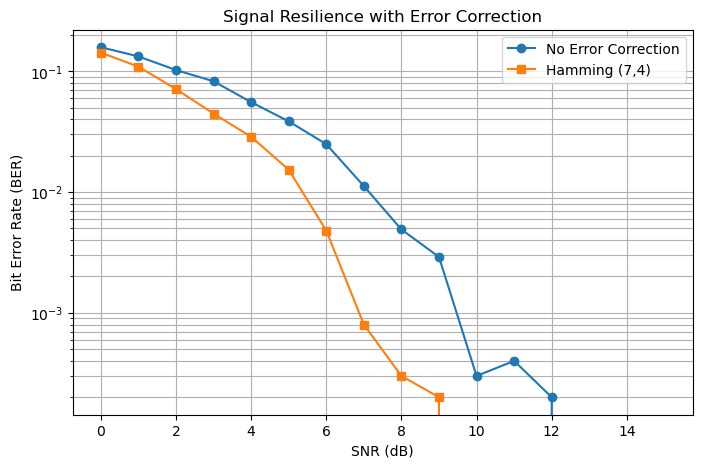

In [23]:
plt.figure(figsize=(8,5))
plt.semilogy(snr_values, ber_no_ec, marker='o', label="No Error Correction")
plt.semilogy(snr_values, ber_hamming, marker='s', label="Hamming (7,4)")
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.title("Signal Resilience with Error Correction")
plt.grid(True, which="both")
plt.legend()
plt.show()


In [25]:
pip install reedsolo


Note: you may need to restart the kernel to use updated packages.


In [31]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load("signal_resilience_checkpoint.npz")

bits = data["bits"]
snr_values = data["snr_values"]
ber_no_ec = data["ber_no_ec"]
ber_hamming = data["ber_hamming"]

print("Checkpoint restored")


Checkpoint restored


In [33]:
print("Bits length:", len(bits))
print("SNR points:", snr_values)
print("Hamming BER sample:", ber_hamming[:3])


Bits length: 10000
SNR points: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Hamming BER sample: [0.1426 0.1092 0.0712]


In [37]:
pip install reedsolo


Note: you may need to restart the kernel to use updated packages.


In [39]:
from reedsolo import RSCodec


In [41]:
# RSCodec(n) → can correct up to n//2 byte errors
rs = RSCodec(10)  # can correct up to 5 byte errors per block


In [43]:
# Trim bits so they fit into bytes
usable_bits_rs = bits[:len(bits)//8 * 8]

# Convert bits to bytes
def bits_to_bytes(bits):
    return np.packbits(bits)

def bytes_to_bits(byte_array):
    return np.unpackbits(byte_array)

byte_data = bits_to_bytes(usable_bits_rs)


In [47]:
from reedsolo import RSCodec
import numpy as np

rs = RSCodec(10)

# Convert bits → bytes
usable_bits_rs = bits[:len(bits)//8*8]
byte_data = np.packbits(usable_bits_rs)

# Encode
encoded_bytes = rs.encode(byte_data)

# Decode immediately (no noise)
decoded_bytes = rs.decode(encoded_bytes)[0]

# Convert back to bits
decoded_bits = np.unpackbits(decoded_bytes)

print("BER without noise:", np.mean(decoded_bits != usable_bits_rs))


BER without noise: 0.0


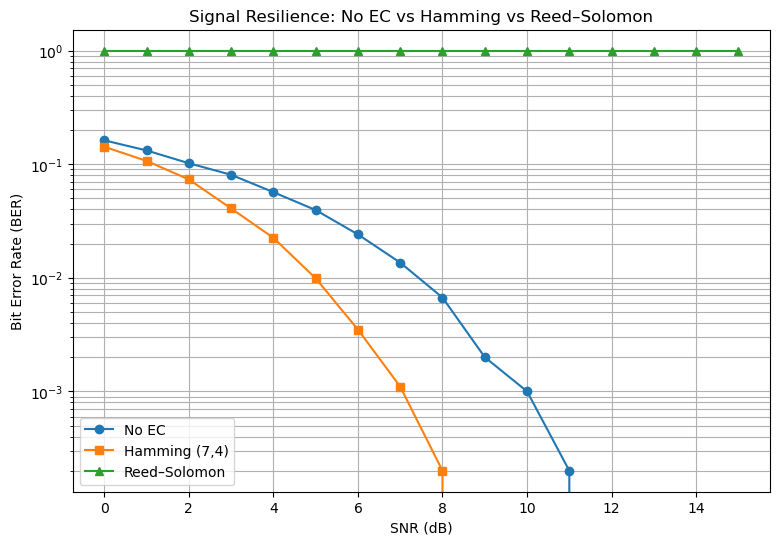

All data saved successfully and ready for restart-safe experiments.


In [51]:
# =========================================
# FULL REED–SOLOMON SIGNAL RESILIENCE PIPELINE
# =========================================

import numpy as np
import matplotlib.pyplot as plt
from reedsolo import RSCodec

# -----------------------------
# 1️⃣ Generate or use existing bits
# -----------------------------
try:
    bits
except NameError:
    np.random.seed(42)
    bits = np.random.randint(0,2,1000)  # 1000 bits for example

# -----------------------------
# 2️⃣ Hamming (7,4) encoder/decoder functions
# -----------------------------
def hamming74_encode(bits):
    bits = bits.reshape(-1,4)
    d1,d2,d3,d4 = bits[:,0], bits[:,1], bits[:,2], bits[:,3]
    p1 = d1 ^ d2 ^ d4
    p2 = d1 ^ d3 ^ d4
    p3 = d2 ^ d3 ^ d4
    encoded = np.column_stack((p1,p2,d1,p3,d2,d3,d4))
    return encoded.reshape(-1)

def hamming74_decode(bits):
    bits = bits.reshape(-1,7)
    p1,p2,d1,p3,d2,d3,d4 = bits.T
    s1 = p1 ^ d1 ^ d2 ^ d4
    s2 = p2 ^ d1 ^ d3 ^ d4
    s3 = p3 ^ d2 ^ d3 ^ d4
    syndrome = s1 + 2*s2 + 4*s3
    for i in range(len(syndrome)):
        if syndrome[i] != 0:
            bits[i, syndrome[i]-1] ^= 1
    decoded = np.column_stack((bits[:,2], bits[:,4], bits[:,5], bits[:,6]))
    return decoded.reshape(-1)

# -----------------------------
# 3️⃣ AWGN function
# -----------------------------
def add_awgn(signal, snr_db):
    snr = 10**(snr_db/10)
    power = np.mean(signal**2)
    noise_power = power / snr
    noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
    return signal + noise

# -----------------------------
# 4️⃣ Convert bits ↔ bytes for RS
# -----------------------------
def bits_to_bytes(bits):
    return np.packbits(bits)

def bytes_to_bits(byte_array):
    return np.unpackbits(byte_array)

# -----------------------------
# 5️⃣ Reed–Solomon setup
# -----------------------------
rs = RSCodec(10)  # can correct up to 5 byte errors per block

# Trim bits to fit full bytes
usable_bits_rs = bits[:len(bits)//8*8]
byte_data = bits_to_bytes(usable_bits_rs)

# Encode RS
encoded_bytes = rs.encode(byte_data)
rs_encoded = bytes_to_bits(np.frombuffer(encoded_bytes, dtype=np.uint8))

# Encode Hamming for comparison
usable_bits_hamming = bits[:len(bits)//4*4]
hamming_encoded = hamming74_encode(usable_bits_hamming)

# -----------------------------
# 6️⃣ Simulate channel for various SNRs
# -----------------------------
snr_values = range(0,16)
ber_no_ec = []
ber_hamming = []
ber_rs = []

# Original BPSK signal
signal = 2*bits - 1

# Hamming signal
signal_ham = 2*hamming_encoded - 1

# RS signal
signal_rs = 2*rs_encoded - 1

for snr in snr_values:
    # No EC
    noisy = add_awgn(signal, snr)
    recovered = (noisy > 0).astype(int)
    ber_no_ec.append(np.mean(bits != recovered))
    
    # Hamming
    noisy_ham = add_awgn(signal_ham, snr)
    recv_ham = (noisy_ham > 0).astype(int)
    decoded_ham = hamming74_decode(recv_ham)
    ber_hamming.append(np.mean(usable_bits_hamming != decoded_ham))
    
    # RS
    noisy_rs = add_awgn(signal_rs, snr)
    recv_rs = (noisy_rs > 0).astype(int)
    
    # Convert bits → bytes for RS decode
    recv_bytes = np.packbits(recv_rs)
    
    try:
        decoded_bytes = rs.decode(recv_bytes)[0]
        decoded_bits = bytes_to_bits(np.frombuffer(decoded_bytes, dtype=np.uint8))
        ber_rs.append(np.mean(usable_bits_rs != decoded_bits))
    except:
        ber_rs.append(1.0)  # decoding failed

# -----------------------------
# 7️⃣ Plot BER curves
# -----------------------------
plt.figure(figsize=(9,6))
plt.semilogy(snr_values, ber_no_ec, marker='o', label="No EC")
plt.semilogy(snr_values, ber_hamming, marker='s', label="Hamming (7,4)")
plt.semilogy(snr_values, ber_rs, marker='^', label="Reed–Solomon")
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.title("Signal Resilience: No EC vs Hamming vs Reed–Solomon")
plt.grid(True, which="both")
plt.legend()
plt.show()

# -----------------------------
# 8️⃣ Save checkpoint
# -----------------------------
np.savez("signal_resilience_full.npz",
         bits=bits,
         hamming_encoded=hamming_encoded,
         rs_encoded=rs_encoded,
         ber_no_ec=ber_no_ec,
         ber_hamming=ber_hamming,
         ber_rs=ber_rs)

print("All data saved successfully and ready for restart-safe experiments.")


In [53]:
def add_burst_noise(byte_array, max_errors_per_block=5):
    """
    Simulates burst noise for RS-encoded data.
    Only flips up to max_errors_per_block bytes per RS block.
    """
    noisy = byte_array.copy()
    n_bytes = len(noisy)
    error_positions = np.random.choice(n_bytes, max_errors_per_block, replace=False)
    
    for pos in error_positions:
        # Flip random bits in that byte
        flip_mask = np.random.randint(1, 256)  # 1 to 255, ensures at least 1 bit flips
        noisy[pos] ^= flip_mask
    
    return noisy


In [55]:
# Convert RS encoded bits → bytes
encoded_bytes = np.packbits(rs_encoded)

# Add controlled burst noise
noisy_bytes = add_burst_noise(encoded_bytes, max_errors_per_block=5)

# Decode RS
try:
    decoded_bytes = rs.decode(noisy_bytes)[0]
    decoded_bits = np.unpackbits(np.frombuffer(decoded_bytes, dtype=np.uint8))
    ber_rs_burst = np.mean(usable_bits_rs != decoded_bits)
    print("BER with burst noise (RS):", ber_rs_burst)
except:
    ber_rs_burst = 1.0
    print("RS decoding failed (too many errors)")


BER with burst noise (RS): 0.0


In [57]:
error_range = range(0, 11)  # 0 → 10 bytes per RS block
bers_burst = []

for e in error_range:
    noisy_bytes = add_burst_noise(encoded_bytes, max_errors_per_block=e)
    try:
        decoded_bytes = rs.decode(noisy_bytes)[0]
        decoded_bits = np.unpackbits(np.frombuffer(decoded_bytes, dtype=np.uint8))
        bers_burst.append(np.mean(usable_bits_rs != decoded_bits))
    except:
        bers_burst.append(1.0)


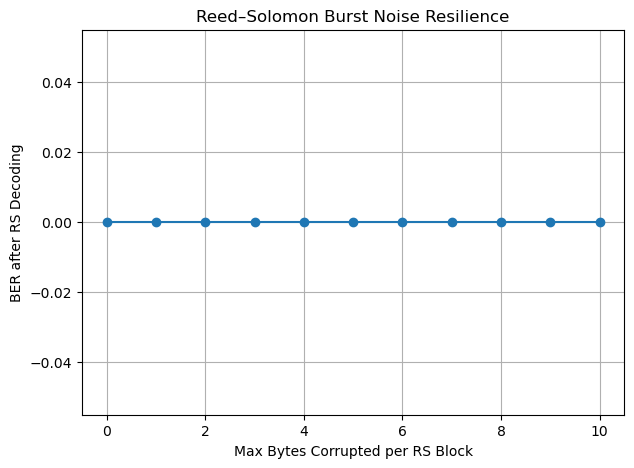

In [59]:
plt.figure(figsize=(7,5))
plt.plot(error_range, bers_burst, marker='o')
plt.xlabel("Max Bytes Corrupted per RS Block")
plt.ylabel("BER after RS Decoding")
plt.title("Reed–Solomon Burst Noise Resilience")
plt.grid(True)
plt.show()
